# Multi-subject dictionary learning & CanICA

**Reference:**

  * [Dictionary Learning and ICA for doing group analysis of resting-state fMRI](http://nilearn.github.io/auto_examples/03_connectivity/plot_compare_resting_state_decomposition.html)
  * [nilearn.decomposition.DictLearning](http://nilearn.github.io/modules/generated/nilearn.decomposition.DictLearning.html)
  * [nilearn.decomposition.CanICA](http://nilearn.github.io/modules/generated/nilearn.decomposition.CanICA.html)
  * [CanICA](https://github.com/GaelVaroquaux/canica)

This example applies dictionary learning and ICA to resting-state data, visualizing resulting components using atlas plotting tools.

Dictionary learning is a sparsity based decomposition method for extracting spatial maps. It extracts maps that are naturally sparse and usually cleaner than ICA.
CanICA is an ICA method for group-level analysis of fMRI data. Compared to other strategies, it brings a well-controlled group model, as well as a thresholding algorithm controlling for specificity and sensitivity with an explicit model of the signal. 

  * G. Varoquaux et al. “A group model for stable multi-subject ICA on fMRI datasets”, NeuroImage Vol 51 (2010), p. 288-299
  * G. Varoquaux et al. “ICA-based sparse features recovery from fMRI datasets”, IEEE ISBI 2010, p. 1177
  * Gael Varoquaux et al. Multi-subject dictionary learning to segment an atlas of brain spontaneous activity Information Processing in Medical Imaging, 2011, pp. 562-573, Lecture Notes in Computer Science

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import nibabel as nib
from skimage import io
import matplotlib.pylab as plt
import notebooks.notebook_utils as uts

/mnt/datagrid/personal/borovec/Applications/vEnv2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/mnt/datagrid/personal/borovec/Applications/vEnv2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## load datset

loading dataset: (True) exists -> /datagrid/Medical/microscopy/drosophila/synthetic_data/atomicPatternDictionary_v0/datasetFuzzy_raw
loading (True) <- /datagrid/Medical/microscopy/drosophila/synthetic_data/atomicPatternDictionary_v0/dictionary/atlas.png


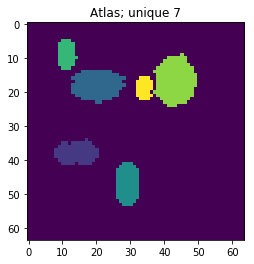

In [2]:
# uts.DEFAULT_PATH = '/datagrid/Medical/microscopy/drosophila/synthetic_data/atomicPatternDictionary_v0'
p_dataset = os.path.join(uts.DEFAULT_PATH, uts.SYNTH_DATASETS_FUZZY[0])
print ('loading dataset: ({}) exists -> {}'.format(os.path.exists(p_dataset), p_dataset))

p_atlas = os.path.join(uts.DEFAULT_PATH, 'dictionary/atlas.png')
atlas_gt = io.imread(p_atlas)
nb_patterns = len(np.unique(atlas_gt))
print ('loading ({}) <- {}'.format(os.path.exists(p_atlas), p_atlas))
plt.imshow(atlas_gt, interpolation='nearest')
_ = plt.title('Atlas; unique %i' % nb_patterns)

In [3]:
list_imgs = uts.load_dataset(p_dataset)
print ('loaded # images: ', len(list_imgs))
img_shape = list_imgs[0].shape
print ('image shape:', img_shape)

nii_images = [nib.Nifti1Image(np.expand_dims(img, axis=0), affine=np.eye(4)) for img in list_imgs]
mask_full = nib.Nifti1Image(np.expand_dims(np.ones(atlas_gt.shape, dtype=np.int8), axis=0), affine=np.eye(4))

('loaded # images: ', 800)
('image shape:', (64, 64))


('shape:', (1, 64, 64))
('values:', array([1], dtype=int8))


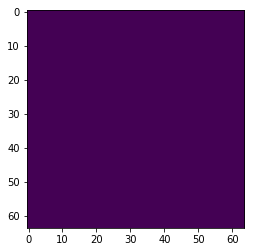

In [17]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(low_pass=0.5, verbose=0)
masker.fit(nii_images)
print ('shape:', masker.mask_img_.get_data().shape)
print ('values:', np.unique(masker.mask_img_.get_data()))
_= plt.imshow(masker.mask_img_.get_data()[0])

## CanICA

CanICA is an ICA method for group-level analysis of fMRI data. Compared to other strategies, it brings a well-controlled group model, as well as a thresholding algorithm controlling for specificity and sensitivity with an explicit model of the signal. 

[nilearn.decomposition.CanICA](http://nilearn.github.io/modules/generated/nilearn.decomposition.CanICA.html)

In [10]:
from nilearn.decomposition import CanICA
canica = CanICA(mask=mask_full, n_components=nb_patterns, 
                mask_strategy='background',
                threshold='auto', n_init=5, verbose=0)
canica.fit(nii_images)

/mnt/datagrid/personal/borovec/Applications/vEnv2/lib/python2.7/site-packages/nilearn/signal.py:139: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/mnt/datagrid/personal/borovec/Applications/vEnv2/lib/python2.7/site-packages/nilearn/signal.py:51: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None,
    mask=<nibabel.nifti1.Nifti1Image object at 0x7f8634425510>,
    mask_args=None, mask_strategy='background',
    memory=Memory(cachedir=None), memory_level=0, n_components=7, n_init=5,
    n_jobs=1, random_state=None, smoothing_fwhm=6, standardize=True,
    t_r=None, target_affine=None, target_shape=None, threshold='auto',
    verbose=0)

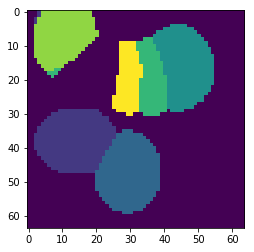

In [11]:
components = np.argmax(canica.components_, axis=0) + 1
atlas = components.reshape(atlas_gt.shape)
plt.imshow(atlas)

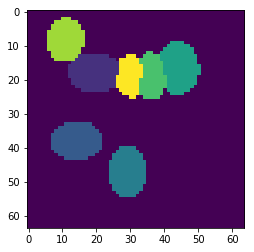

In [12]:
max_ptn = np.max(canica.components_, axis=0).reshape(atlas_gt.shape)
atlas[max_ptn < np.mean(max_ptn[max_ptn > 0])] = 0
plt.imshow(atlas)

## Dictionary Learning

Perform a map learning algorithm based on spatial component sparsity, over a CanICA initialization. This yields more stable maps than CanICA.

[nilearn.decomposition.DictLearning](http://nilearn.github.io/modules/generated/nilearn.decomposition.DictLearning.html) 

In [15]:
from nilearn.decomposition import DictLearning
dict_learn = DictLearning(mask=mask_full, n_components=nb_patterns,
                          mask_strategy='background',
                          verbose=0, n_epochs=10)
dict_learn.fit(nii_images)

DictLearning(alpha=10, batch_size=20, detrend=True, dict_init=None,
       high_pass=None, low_pass=None,
       mask=<nibabel.nifti1.Nifti1Image object at 0x7f8634425510>,
       mask_args=None, mask_strategy='background',
       memory=Memory(cachedir=None), memory_level=0, method='cd',
       n_components=7, n_epochs=10, n_jobs=1, random_state=None,
       reduction_ratio='auto', smoothing_fwhm=4, standardize=True,
       t_r=None, target_affine=None, target_shape=None, verbose=0)

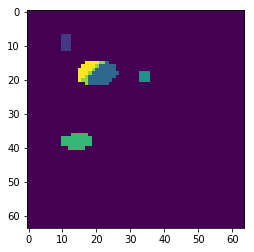

In [16]:
components = np.argmax(dict_learn.components_, axis=0) + 1
atlas = components.reshape(atlas_gt.shape)
plt.imshow(atlas)